## Imports and node intialization ##

In [134]:
from geometry_msgs.msg import Twist
from sensor_msgs.msg import LaserScan
from move_base_msgs.msg import MoveBaseActionGoal, MoveBaseActionFeedback
from actionlib_msgs.msg import GoalID, GoalStatusArray
from nav_msgs.msg import Odometry
from IPython.display import display, clear_output
from ipywidgets import interactive_output
from jupyros import ros3d
import os
import ipywidgets as widgets
import jupyros as jr
import rospy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# definition of global variables
flag = False
assisted = False
status = -1

rospy.init_node("robot_controller") # initiliaze the node
pubV = rospy.Publisher("/cmd_vel", Twist, queue_size = 1) # initialize a publisher to the /cmd_vel topic
pubG = rospy.Publisher("/move_base/goal", MoveBaseActionGoal, queue_size = 1) # initialize a publisher to the /move_base/goal topic
pubC = rospy.Publisher("/move_base/cancel", GoalID, queue_size = 1) # initialize a publisher to the /move_base/cancel topic

## Subscriber to the /move_base/status topic ##

In [135]:
reached, canceled = 0, 0

def getStatus(msg):
    
    global flag, reached, canceled
    
    if flag == True:
    
        goal_id = GoalID()
        status = msg.status_list[0].status

        if status == 3:
            print("The goal was successfully reached!")
            status = -1
            pubC.publish(goal_id)
            reached += 1
            flag = False

        if status == 4:
            print("The goal was aborted!")
            status = -1
            pubC.publish(goal_id)
            canceled += 1
            flag = False

        if status == 5:
            print("The goal was rejected!")
            status = -1
            pubC.publish(goal_id)
            canceled += 1
            flag = False
        
subS = rospy.Subscriber("/move_base/status", GoalStatusArray, getStatus)

## Subscriber to the /scan topic ##

In [136]:
wall_th = 1 # wall threshold

def assistedDrive(msg):
    # Function to plot the laser scanner and to avoid the collision with the walls
    global assisted, lin, ang
    
    if assisted == True:
        vel = Twist()

        # Distance of the closest obstacle on the right, front, left of the robot
        right = min(min(msg.ranges[0:69]), 1)     
        front = min(min(msg.ranges[300:419]), 1)   
        left = min(min(msg.ranges[650:719]), 1)     

        vel.linear.x = lin
        vel.angular.z = ang
        
        if front < wall_th:
            vel.linear.x = 0
        elif left < wall_th:
            vel.angular.z = -1
        elif right < wall_th:
            vel.angular.z = 1
        else:
            pass

        pubV.publish(vel)
            
subL = rospy.Subscriber('/scan', LaserScan, assistedDrive)    

## Subscriber to the /cmd_vel topic ##

In [137]:
def updateVel(msg):
    
    global lin, ang
    
    lin = msg.linear.x
    ang = msg.angular.z
    
subV = rospy.Subscriber("/cmd_vel", Twist, updateVel)

## Definition of widgets ##

In [138]:
# Widget to prompt the user
driving_mode = widgets.ToggleButtons(
    options=[("Reach point", 1), ("Drive manually", 2)],
    description="Options:",
    value=1,
    disabled=False,
    button_style='',
)

# Widgets for the reachPoint function
buttonSet = widgets.Button(description = "Set new goal")
buttonCanc = widgets.Button(description = "Cancel current goal")
setX = widgets.FloatText(
    description="X coordinate:",
    disabled=False
)
        
setY = widgets.FloatText(
    description="Y coordinate:",
    disabled=False
)

# Widgets for the driveManually function
assistedDrive = widgets.Checkbox(
    value=False,
    description="Assisted drive",
    disabled=False,
    indent=False
)
buttonFront = widgets.Button(description = "Go forward")
buttonRight = widgets.Button(description = "Turn right")
buttonBack = widgets.Button(description = "Go backward")
buttonLeft = widgets.Button(description = "Turn left")
buttonIncrease = widgets.Button(description = "Increase vel")
buttonDecrease = widgets.Button(description = "Decrease vel")
buttonStop = widgets.Button(description = "Stop robot")

In [139]:
def reachPoint():
    
    with output1:
        clear_output(wait=True)
        
        outputSet = widgets.Output()
        outputCanc = widgets.Output()
        
        display(setX, setY, buttonSet, outputSet)
        display(buttonCanc, outputCanc)
        
        def setGoal(b):
            
            global flag
            
            with outputSet:
                clear_output(wait=True)
                xCoord = float(setX.value)
                yCoord = float(setY.value)
                print("Current goal: (%f, %f)" % (xCoord, yCoord))

                my_goal = MoveBaseActionGoal()
                my_goal.goal.target_pose.pose.position.x = xCoord
                my_goal.goal.target_pose.pose.position.y = yCoord 
                my_goal.goal.target_pose.header.frame_id = "map"
                my_goal.goal.target_pose.pose.orientation.w = 1

                pubG.publish(my_goal)
                flag = True
                
        def cancelGoal(b):
            
            global flag, canceled
            
            with outputCanc:
                clear_output(wait=True)
                if flag == True:
                    id_cancel = GoalID()
                    pubC.publish(id_cancel)
                    print("The goal has been correctly cancelled!")
                    canceled += 1
                else:
                    print("No goal has been set yet!")
                    
            flag = False
                   
        buttonSet.on_click(setGoal)
        buttonCanc.on_click(cancelGoal)  

In [140]:
acc = 1 # acceleration factor, initally set at 1

def driveManually():
    
    with output2:
        clear_output(wait=True)
        
        global lin, ang, acc
        
        display(assistedDrive)
        display(buttonFront, buttonRight, buttonBack, buttonLeft)
        display(buttonIncrease, buttonDecrease, buttonStop)
        
        vel = Twist()
        
        def setAssisted(b):
            global assisted
            if assisted == False:
                assisted = True
            else:
                assisted = False
        
        def front(b):
            vel.linear.x = 0.5
            vel.angular.z = 0
            pubV.publish(vel)

        def right(b):
            vel.linear.x = 0
            vel.angular.z = -1
            pubV.publish(vel)

        def back(b):
            vel.linear.x = -0.5
            vel.angular.z = 0
            pubV.publish(vel)

        def left(b):
            vel.linear.x = 0
            vel.angular.z = 1
            pubV.publish(vel)
            
        def increaseVel(b):
            global lin ,ang, acc
            acc += 0.25
            if acc >= 1 and acc <= 2:
                lin *= acc
                ang *= acc
            vel.linear.x = lin
            vel.angular.z = ang
            pubV.publish(vel)

        def decreaseVel(b):
            global lin, ang, acc
            acc -= 0.25
            if acc >= 0 and acc <= 1:
                lin *= acc
                ang *= acc
            vel.linear.x = lin
            vel.angular.z = ang
            pubV.publish(vel)
            
        def stopRobot(b):
            vel.linear.x = 0
            vel.angular.z = 0
            pubV.publish(vel)
        
        assistedDrive.observe(setAssisted)
        buttonFront.on_click(front)
        buttonRight.on_click(right)
        buttonBack.on_click(back)
        buttonLeft.on_click(left)
        buttonIncrease.on_click(increaseVel)
        buttonDecrease.on_click(decreaseVel)
        buttonStop.on_click(stopRobot)

In [141]:
display(driving_mode)

def choose(mode):
    
    if mode == 1:
        reachPoint()
        
    if mode == 2:
        driveManually()
        
interactive_output(choose, {'mode': driving_mode})        

output1 = widgets.Output()
output2 = widgets.Output()

display(output1)
display(output2)

ToggleButtons(description='Options:', options=(('Reach point', 1), ('Drive manually', 2)), value=1)

Output()

Output()

## View of the robot ##

In [142]:
v = ros3d.Viewer()
rc = ros3d.ROSConnection(url="ws://localhost:9090")
tf_client = ros3d.TFClient(ros=rc, fixed_frame='map')
laser_view = ros3d.LaserScan(topic="/scan", ros=rc, tf_client=tf_client)
map_view = ros3d.OccupancyGrid(topic="/map", ros=rc, tf_client=tf_client)
path = ros3d.Path(topic="/move_base/NavfnROS/plan", ros=rc,
tf_client=tf_client)
urdf = ros3d.URDFModel(ros=rc, tf_client=tf_client,
path=os.environ.get('JUPYROS_ASSETS_URL', 'http://localhost:3000'))
g = ros3d.GridModel()
v.objects = [g, laser_view, map_view, path, urdf]
v

Viewer(objects=[GridModel(), LaserScan(ros=ROSConnection(url='ws://localhost:9090'), tf_client=TFClient(fixed_…

# Robot's behaviour #

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


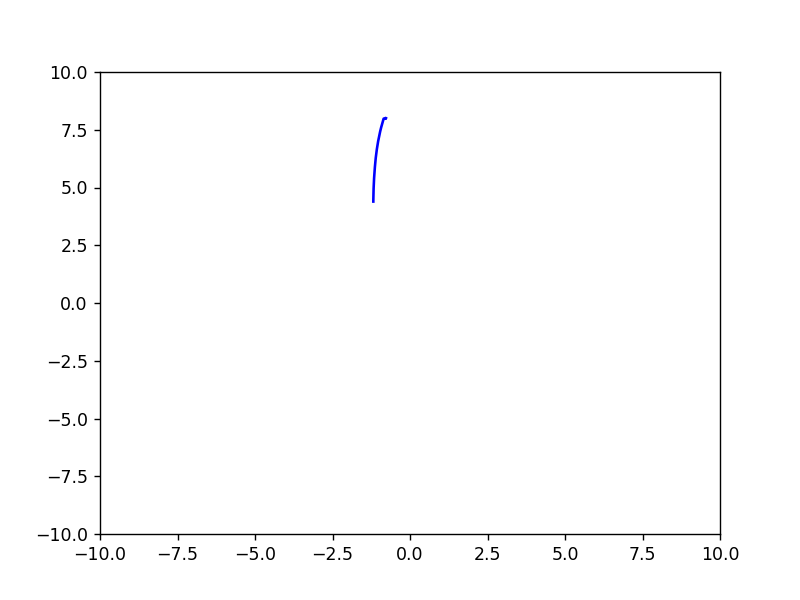

In [146]:
%matplotlib widget

# Visualization of the odometry

class Visualiser:
    
    def __init__(self):
        
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'b-')
        self.x_data, self.y_data = [] , []
        
    def plot_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        return self.ln
    
    def odom_callback(self, msg):
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)
        
    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln
    
vis = Visualiser()
subS = rospy.Subscriber('/odom', Odometry, vis.odom_callback)
ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init)
plt.show(block=True)

<IPython.core.display.Javascript object>


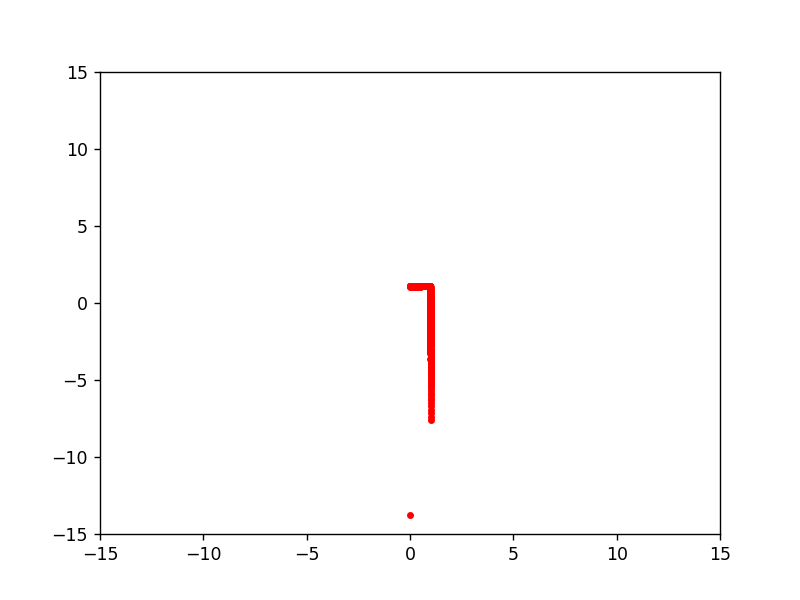

In [144]:
# Visualization of the laser scan

import math
class Visualiser:
    def __init__(self):
        
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'r.')
        self.x_plot, self.y_plot = [], []
    
    def plot_init(self):
        self.ax.set_xlim(-15,15)
        self.ax.set_ylim(-15,15)
        return self.ln
        
    def scanner_callback(self, msg):
        self.x_plot = []
        self.y_plot = []
        angle = msg.angle_min
        
        for i in range(0, len(msg.ranges)):
            self.x_plot.append(msg.ranges[i]*math.cos(angle))
            self.y_plot.append(msg.ranges[i]*math.sin(angle))
            angle = angle + msg.angle_increment
            
    def update_plot(self, frame):
        self.ln.set_data(self.x_plot, self.y_plot)
        return self.ln
        

vis = Visualiser()
sub = rospy.Subscriber('/scan', LaserScan, vis.scanner_callback)
ani = FuncAnimation(vis.fig, vis.update_plot, init_func = vis.plot_init)
plt.show(block = True)

In [145]:
# Visualization of the goals

buttonGoals = widgets.Button(description = "Show goals history")
display(buttonGoals)

def showGoals(b):
    clear_output(wait=True)
    fig2, ax3 = plt.subplots()
    ax3.cla()
    reachedGoals = (reached); 
    canceledGoals = (canceled); 
    index = np.arange(1);
    ax3.bar(index, reachedGoals, align='edge', width=0.35, alpha=0.4, color='g', label='Reached goals')
    ax3.bar(index+0.35, canceledGoals, align='edge', width=0.35, alpha=0.40, color='r', label='Canceled goals')
    plt.title('Goals history')
    plt.legend()
    plt.show()
    
buttonGoals.on_click(showGoals)

Button(description='Show goals history', style=ButtonStyle())